<a href="https://colab.research.google.com/github/alecbidaran/Simple-deep-learning-projects/blob/main/Explainable_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pathlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
 
import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen
import cv2 
import tensorflow as tf
import tensorflow_hub as hub
from matplotlib.cm    import get_cmap
import tensorflow.keras.backend as K
from tensorflow.python.ops   import gen_nn_ops
import sys
 
tf.get_logger().setLevel('ERROR')

In [2]:
model=tf.keras.models.Sequential([
              hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),
              tf.keras.layers.Activation('softmax')                    
])
model.build([None,300,300,3])

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              23853833  
_________________________________________________________________
activation (Activation)      (None, 1001)              0         
Total params: 23,853,833
Trainable params: 0
Non-trainable params: 23,853,833
_________________________________________________________________


In [4]:
!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

--2021-05-16 10:28:43--  https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.21.183, 104.18.20.183, 2606:4700::6812:14b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.21.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165993 (162K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 162.10K  --.-KB/s    in 0.005s  

2021-05-16 10:28:44 (31.2 MB/s) - ‘image.jpg’ saved [165993/165993]



In [5]:
import cv2 

In [46]:
img = cv2.imread('image.jpg')

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (300, 300)) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)

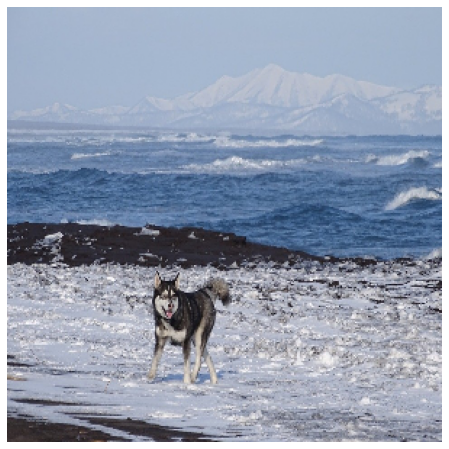

In [47]:
plt.figure(figsize=(8, 8))
plt.imshow(np.squeeze(img))
plt.axis('off')
plt.show()

In [48]:
class_index = 251   

# If you downloaded the cat, use this line instead
#class_index = 282   # Tabby Cat in ImageNet

# number of classes in the model's training data
num_classes = 1001

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)
with tf.GradientTape() as tape:
  inputs=tf.cast(image,dtype=tf.float32)
  tape.watch(inputs)
  pred=model(inputs)
  loss=tf.keras.losses.categorical_crossentropy(expected_output,pred)
grads=tape.gradient(loss,inputs)
grad_input=np.squeeze(image)*np.squeeze(grads)

In [49]:
print(grad_input.shape)

(300, 300, 3)


In [50]:
gray_grads=tf.reduce_sum(tf.abs(grad_input),axis=-1)
normalized_grads=tf.cast(255*(gray_grads-tf.reduce_min(gray_grads)/(tf.reduce_max(gray_grads) - tf.reduce_min(gray_grads))),tf.uint8)

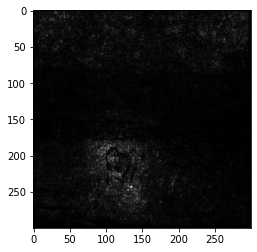

In [51]:
plt.imshow(np.squeeze(normalized_grads.numpy()),cmap="gray")

In [52]:
#normalized_grads=tf.squeeze(normalized_grads)
color_map=cv2.applyColorMap(normalized_grads.numpy(),cv2.COLORMAP_HOT)
color_map=color_map/255.0
weighted=cv2.addWeighted(img,0.6,color_map,0.6,0.0)

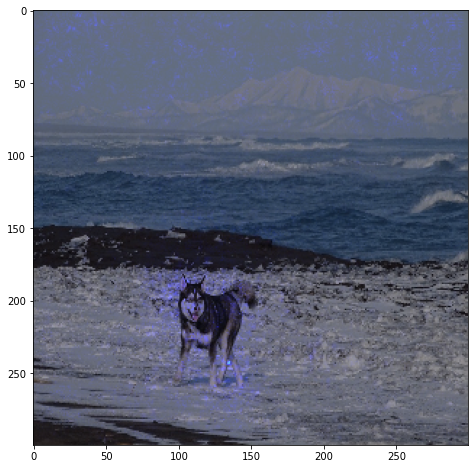

In [53]:
plt.figure(figsize=(8,8))
plt.imshow(weighted)

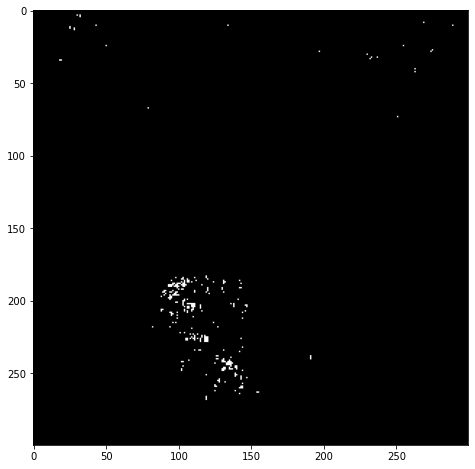

In [54]:
grads=normalized_grads.numpy()
_,thresh=cv2.threshold(grads,50,255,cv2.THRESH_BINARY)
thresh
plt.figure(figsize=(8,8))
plt.imshow(thresh,cmap='gray')

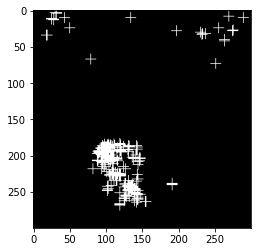

In [55]:
kernel_size_5_5 = (15,15)
kernel_dilate=cv2.getStructuringElement(cv2.MORPH_DILATE,kernel_size_5_5)
dilation=cv2.dilate(thresh,kernel_dilate,iterations=1)
plt.imshow(dilation,cmap='gray')

In [56]:
countours,hierichy=cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

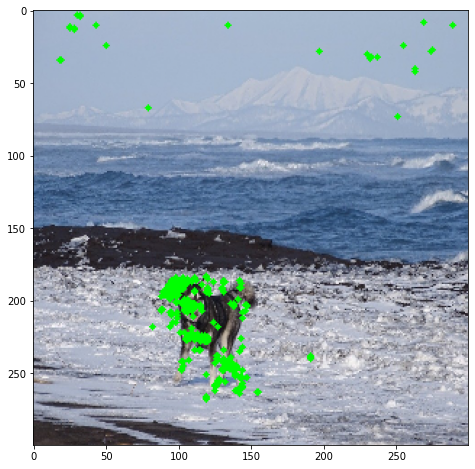

In [58]:
for cnt in countours:
  if cnt.all()>200:
    cnt=cnt.reshape((-1,1,2))
  rect=cv2.polylines(img,[cnt],True,(0,255,0),3)
plt.figure(figsize=(8,8))
plt.imshow(rect)

#LPR

In [64]:
actions=[]
weights=[]
name=[]
for layer in resnet.layers:
  actions.append(layer.output)
  weights.append(layer.get_weights())
  name.append(layer.name)


In [65]:
class_index = 251   

# If you downloaded the cat, use this line instead
#class_index = 282   # Tabby Cat in ImageNet

# number of classes in the model's training data
img = cv2.imread('image.jpg')

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (224,224)) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)
num_classes = 1000
# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)
with tf.GradientTape() as tape:
  inputs=tf.cast(image,dtype=tf.float32)
  tape.watch(inputs)
  pred=resnet(inputs)
  loss=tf.keras.losses.categorical_crossentropy(expected_output,pred)
grads=tape.gradient(loss,inputs)
grad_input=np.squeeze(image)*np.squeeze(grads)

In [66]:
gray_grads=tf.reduce_sum(tf.abs(grad_input),axis=-1)
normalized_grads=tf.cast(255*(gray_grads-tf.reduce_min(gray_grads)/(tf.reduce_max(gray_grads) - tf.reduce_min(gray_grads))),tf.uint8)

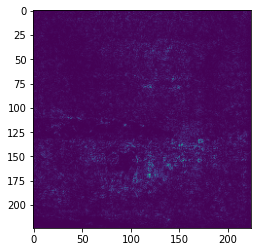

In [67]:
plt.imshow(np.squeeze(gray_grads.numpy()))

In [68]:
class_index = 251   

# If you downloaded the cat, use this line instead
#class_index = 282   # Tabby Cat in ImageNet

# number of classes in the model's training data
img = cv2.imread('image.jpg')

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (224,224)) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)
num_classes = 1000
# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)
with tf.GradientTape() as tape:
  inputs=tf.cast(image,dtype=tf.float32)
  tape.watch(inputs)
  pred=resnet(inputs)
  loss=tf.keras.losses.categorical_crossentropy(expected_output,pred)
grads=tape.gradient(loss,inputs)
grad_input=grads*loss/(inputs+0.5)

In [69]:
gray_grads=tf.reduce_sum(tf.abs(grad_input),axis=-1)
normalized_grads=tf.cast(255*(gray_grads-tf.reduce_min(gray_grads)/(tf.reduce_max(gray_grads) - tf.reduce_min(gray_grads))),tf.uint8)

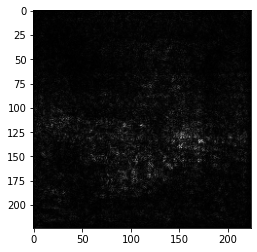

In [72]:
plt.imshow(np.squeeze(gray_grads.numpy()),cmap="gray")

In [71]:
normalized_grads=tf.squeeze(normalized_grads)
color_map=cv2.applyColorMap(normalized_grads.numpy(),cv2.COLORMAP_HOT)
color_map=color_map/255.0
weighted=cv2.addWeighted(img,0.6,color_map,0.6,0.0)